## How to use PCA on APOGEE globular cluster data. 
##### Steffani Grondin (September 23, 2022)
##### Jeremy Webb (March 2023)

#### STEP 0: Import the necessary packages/algorithms.

In [1]:
# General analysis/plotting packages:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from collections import Counter

# Specific t-SNE/visualization packages:
from shapely.geometry import Point, Polygon

# Import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Try using SKLEARN's StandardScaler to standardize the data
from sklearn.preprocessing import StandardScaler



#### STEP 1: Load in the M3 datafile. 

This example uses APOGEE DR17 data (https://www.sdss.org/dr17/) with astroNN chemical abundances (https://astronn.readthedocs.io/en/latest/) and includes all stars that are within a 10x10 degree field of view around M3's centre.

In [2]:
M3 = pd.read_csv('../data/M3data_10x10.csv', delimiter=',')

# Spatial:
ra = M3["ra"]   #APOGEE
dec = M3["dec"]   #APOGEE

# Identification:
apogee_ID = M3["apogee_ID"]   #APOGEE
gaia_ID = M3["gaia_ID"]  # Gaia

# Kinematic:
parallax = M3["parallax"]  # Gaia
pmra = M3["pmra"]  # Gaia
pmra_err = M3["pmra_err"]  # Gaia
pmdec = M3["pmdec"]  # Gaia
pmdec_err = M3["pmdec_err"]  # Gaia
RV = M3["RV"]   #APOGEE
RV_err = M3["RV_err"]   #APOGEE
dist = M3["dist"]   #APOGEE
dist_err = M3["dist_err"]   #APOGEE
jr = M3["jr"]   #APOGEE
jr_err = M3["jr_err"]   #APOGEE
jz = M3["jz"]   #APOGEE
jz_err = M3["jz_err"]   #APOGEE
jphi = M3["jphi"]   #APOGEE
jphi_err = M3["jphi_err"]    #APOGEE

# Spectral (useful for filtering):
TEFF_ERR = M3["TEFF_err"]   #APOGEE
TEFF = M3["TEFF"]   #APOGEE
LOGG_ERR = M3["LOGG_err"]   #APOGEE
LOGG = M3["LOGG"]   #APOGEE
SNR = M3["SNR"]   #APOGEE

# Chemical abundances from astroNN:
FE_H = M3['FEH'] 
C_FE = M3['CFE']
CI_FE = M3['CIFE']
N_FE = M3['NFE']
O_FE = M3['OFE']
MG_FE = M3['MGFE']
AL_FE = M3['ALFE']
SI_FE = M3['SIFE']
P_FE = M3['PFE']
S_FE = M3['SFE']
K_FE = M3['KFE']
CA_FE = M3['CAFE']
TI_FE = M3['TIFE']
TIII_FE = M3['TIIIFE']
V_FE = M3['VFE']
CR_FE = M3['CRFE']
MN_FE = M3['MNFE']
CO_FE = M3['COFE']
NI_FE = M3['NIFE']

# Chemical abundance errors from astroNN:
FE_H_err = M3["FEH_err"] 
C_FE_err = M3['CFE_err']
CI_FE_err = M3['CIFE_err']
N_FE_err = M3['NFE_err']
O_FE_err = M3['OFE_err']
MG_FE_err = M3['MGFE_err']
AL_FE_err = M3['ALFE_err']
SI_FE_err = M3['SIFE_err']
P_FE_err = M3['PFE_err']
S_FE_err = M3['SFE_err']
K_FE_err = M3['KFE_err']
CA_FE_err = M3['CAFE_err']
TI_FE_err = M3['TIFE_err']
TIII_FE_err = M3['TIIIFE_err']
V_FE_err = M3['VFE_err']
CR_FE_err = M3['CRFE_err']
MN_FE_err = M3['MNFE_err']
CO_FE_err = M3['COFE_err']
NI_FE_err = M3['NIFE_err']

# Number of stars in the initial sample of APOGEE DR16: 
print("There are {} stars in our initial sample".format(len(ra)))

cols = [ra, dec, apogee_ID, gaia_ID, parallax, pmra, pmra_err, pmdec, pmdec_err, RV, RV_err, dist, dist_err,
        jr, jr_err, jphi, jphi_err, jz, jz_err, TEFF, TEFF_ERR, LOGG, LOGG_ERR, SNR, FE_H, FE_H_err, C_FE, 
        C_FE_err, CI_FE, CI_FE_err, N_FE, N_FE_err, O_FE, O_FE_err, MG_FE, MG_FE_err, AL_FE, AL_FE_err, SI_FE,
        SI_FE_err, P_FE, P_FE_err, S_FE, S_FE_err, K_FE, K_FE_err, CA_FE, CA_FE_err, TI_FE, TI_FE_err, TIII_FE,
        TIII_FE_err, V_FE, V_FE_err, CR_FE, CR_FE_err, MN_FE, MN_FE_err, CO_FE, CO_FE_err, NI_FE, NI_FE_err]

There are 5289 stars in our initial sample


#### STEP 2: Filter the data. 

First, we remove all stars without proper motions and chemical abundances for all 19 elements. Next, for stars with multiple spectra, we select the one with the highest SNR to represent the source. Finally, we remove all stars with low signal-to-noise (SNR) ratios. 

In [3]:
### Filter 1: Remove stars that do not have proper motion values. ###
pm_filter = np.invert(np.isnan(np.array(pmra)))
print("There are {} stars in our sample after the proper motion filtering.".format(np.sum(pm_filter)))

### Filter 2: Remove stars that do not have data for all 19 abundances. ###
abundance_filter = np.ones(len(pm_filter),dtype=bool)
for i in range(0,19):
    abundance_filter*=np.array(cols[int(24+2*i)]) > -9999
print("There are {} stars in our sample after the abundance filtering.".format(np.sum(pm_filter*abundance_filter)))

### Filter 3: Remove all duplicate spectra (i.e. select spectra with highest SNR for multiple measurements). ###
 
unique_val = np.ones(len(pm_filter),dtype=bool)
ras=np.array(cols[0])
snrs=np.array(cols[23])


for i in range(0,len(ras)):
    indices=(ras==ras[i])
    
    if np.sum(indices)>1:
        snr_vals=snrs[indices]
        max_snr=np.amax(snr_vals)
        unique_val[indices*(snrs<max_snr)]=False
        
        
print("There are {} stars in our sample after removing sources with duplicate spectra.".format(np.sum(pm_filter*abundance_filter*unique_val)))


### Filter 4: Remove all stars with low SNR. ###
SNR_filter = np.array(cols[23]) > 50


filters=pm_filter*abundance_filter*unique_val*SNR_filter

print("There are {} stars in our sample after removing sources with low SNR.".format(np.sum(pm_filter*abundance_filter*unique_val*SNR_filter)))


data_snrfilter = []
for c in cols:
    a = np.array(c)[filters]
    data_snrfilter.append(a)

There are 5240 stars in our sample after the proper motion filtering.
There are 5053 stars in our sample after the abundance filtering.
There are 3269 stars in our sample after removing sources with duplicate spectra.
There are 3184 stars in our sample after removing sources with low SNR.


#### ***CHECK-IN: Now that your data has been reduced, do some exploratory data analysis to see what the sample looks like!*

What parameters are in this file? What parameters might be useful to connect extra-tidal stars with a suspected birth cluster?

#### STEP 3: Define parameters for your GC of interest. 

These parameters are taken from the Baumgardt & Hilker (2018) catalogue: https://people.smp.uq.edu.au/HolgerBaumgardt/globular/.

In [4]:
ra_M3 = 205.548  # [deg]
dec_M3 = 28.3772  # [deg]
dist_M3 = 10180  # [pc]
rt_M3 = 159.0339  # [pc] -- tidal radius @ apogalacticon
rhm_M3 = 6.34  # [pc]
rhm_M3_deg = math.degrees(math.atan(rhm_M3 / dist_M3))  # deg
pmra_M3 = -0.152  # [mas/yr]
pmdec_M3 = -2.670  # [mas/yr]

#### STEP 4: Define a control group of cluster members.

We must define a control group of likely cluster members of M3 so we can see where these stars end up in the t-SNE projection. 

In [5]:
# Select all the stars within some radius of the cluster:
def in_circle(center_x, center_y, radius, x, y):
    square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
    return square_dist <= (radius) ** 2

ra_filtered = data_snrfilter[0]
dec_filtered = data_snrfilter[1]

# Select stars within 8 * r,hm (useful for large enough sample of probable cluster members):
in_halfmass = in_circle(ra_M3, dec_M3, 8*rhm_M3_deg, ra_filtered, dec_filtered)
indices_control = np.where(in_halfmass==True)

controlgroup = []
for i in data_snrfilter:
    b = np.array(i)[indices_control]
    controlgroup.append(b)

# Example control group parameters: 
ra_control = controlgroup[0]
dec_control = controlgroup[1]

print("There are {} stars in our M3 control group.".format(len(ra_control)))

There are 131 stars in our M3 control group.


Text(0, 0.5, 'DEC')

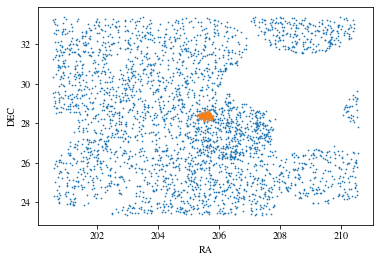

In [38]:
plt.scatter(ra_filtered,dec_filtered,s=0.5)
plt.scatter(ra_control,dec_control,s=0.5)
plt.xlabel('RA')
plt.ylabel('DEC')

#### ***CHECK-IN: Add this control group to your above exploratory plots.* 

What do you notice about these stars? What changes if you adjust the control group radius (i.e. what if you go larger or smaller than 8*r,hm)?


#### STEP 5: Run PCA on the control group and full filtered sample of APOGEE DR17 stars.

First, we standardize the data to ensure that no elements dominate or skew the UMAP run. We want to include 19 chemical abundances and radial velocities in our run.  

In [46]:
pmra_filtered,pmdec_filtered=data_snrfilter[5], data_snrfilter[7]
FE_H_filtered, C_FE_filtered, CI_FE_filtered = data_snrfilter[24], data_snrfilter[26], data_snrfilter[28]
N_FE_filtered, O_FE_filtered, MG_FE_filtered = data_snrfilter[30], data_snrfilter[32], data_snrfilter[34]
AL_FE_filtered, SI_FE_filtered, P_FE_filtered = data_snrfilter[36], data_snrfilter[38], data_snrfilter[40]
S_FE_filtered, K_FE_filtered, CA_FE_filtered = data_snrfilter[42], data_snrfilter[44], data_snrfilter[46]
TI_FE_filtered, TIII_FE_filtered, V_FE_filtered = data_snrfilter[48], data_snrfilter[50], data_snrfilter[52]
CR_FE_filtered, MN_FE_filtered, CO_FE_filtered, NI_FE_filtered = data_snrfilter[54], data_snrfilter[56], data_snrfilter[58], data_snrfilter[60]
RV_filtered  = data_snrfilter[9]

preumap_array = np.array([FE_H_filtered, C_FE_filtered, CI_FE_filtered, N_FE_filtered, O_FE_filtered, MG_FE_filtered,
                      AL_FE_filtered, SI_FE_filtered, P_FE_filtered, S_FE_filtered, K_FE_filtered, CA_FE_filtered, 
                      TI_FE_filtered, TIII_FE_filtered, V_FE_filtered, CR_FE_filtered, MN_FE_filtered, CO_FE_filtered,
                       NI_FE_filtered, RV_filtered,pmra_filtered,pmdec_filtered])

standardized_array = StandardScaler().fit_transform(preumap_array).T


In [47]:
standardized_array.shape

(3184, 22)

Next, we apply PCA to reduce the dimensionality of the data from 20-D to 2-D.

In [48]:
pca = PCA(n_components= 2,whiten=True, random_state=0)
pca.fit(standardized_array)
principalComponents = pca.transform(standardized_array)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


In [49]:
print(pca.explained_variance_ratio_,1 - np.sum(pca.explained_variance_ratio_))

[0.44801126 0.37803871] 0.17395003166510858


In [50]:
# Get PCA outputs for complete filtered dataset:
pca_dimX = principalDf.loc[:, 'principal component 1'].values
pca_dimY = principalDf.loc[:, 'principal component 2'].values

In [51]:
# Get PCA outputs for control group:
pca_dimX_control = pca_dimX[indices_control]
pca_dimY_control = pca_dimY[indices_control]

Finally, we plot the 2-D UMAP projection. 

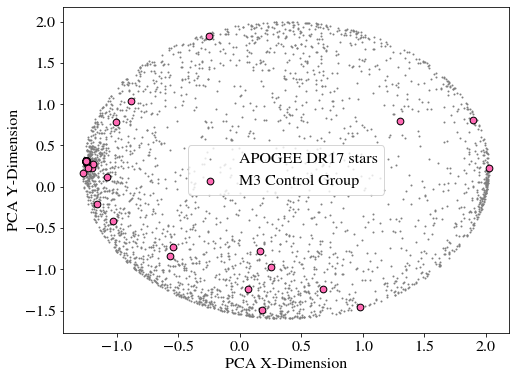

In [52]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(pca_dimX, pca_dimY, s=1, c='gray', label='APOGEE DR17 stars')
ax.scatter(pca_dimX_control , pca_dimY_control, s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
ax.set_xlabel("PCA X-Dimension", fontsize=16)
ax.set_ylabel("PCA Y-Dimension", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.legend(fontsize=16)
plt.show()

#### ***CHECK-IN: You succesfully ran PCA!*

What does this specific PCA projection actually tell you? How could you improve this PCA run? Importantly, how could you extend this method to find extra-tidal candidates of M3?

#### Improving the Dimensionality Reduction
Fine tune the hyper-parameters:
- understand how the different hyper-parameters affect the data
- what combination of hyper-parameters achieve the best separation of the control group?

Helpful documentation:

